In [1]:
##--- Kaggle ---
!pip install kaggle

In [2]:
##--- Upload Kaggle.json ---
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sherr0099","key":"c4ac1ded54c6f7d270f51b48f61578af"}'}

In [3]:
##--- Setup Kaggle API ---
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
##--- Downloading the dataset ---
!kaggle datasets download drscarlat/melanoma

Dataset URL: https://www.kaggle.com/datasets/drscarlat/melanoma
License(s): unknown


In [5]:
##--- Unzipping the dataset ---
!unzip melanoma.zip

Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

In [6]:
##--- Import libraries ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, GaussianNoise, ELU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
##--- Data Preprocessing ---
img_height, img_width = 224, 224
batch_size = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_aug.flow_from_directory(
    '/content/DermMel',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = val_aug.flow_from_directory(
    '/content/dermmel/DermMel',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 14245 images belonging to 3 classes.
Found 3560 images belonging to 3 classes.


In [8]:
##--- Printing Image Size ---
from PIL import Image

image = Image.open("/content/DermMel/test/Melanoma/AUG_0_1001.jpeg")
width, height = image.size
print(f"image size: {width} x {height} pixels")

image size: 224 x 224 pixels


In [9]:
 ##--- Build Models ---
  #--- ResNet50 ---
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:100]:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.1)(x)
    x = Dense(256)(x)
    x = ELU()(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

  #--- EfficientNetB0
def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:len(base_model.layers)//2]:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.15)(x)
    x = Dense(192)(x)
    x = ELU()(x)
    x = Dropout(0.35)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Model Checkpoints
checkpoint_resnet = ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_efficientnet = ModelCheckpoint('best_efficientnet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [10]:
##--- Train ResNet50 ---
resnet_model = build_resnet_model((224, 224, 3), train_data.num_classes)
resnet_model.compile(optimizer=AdamW(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

resnet_history = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint_resnet]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5455 - loss: 1.0794
Epoch 1: val_loss improved from inf to 8.84336, saving model to best_resnet_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 320s 631ms/step - accuracy: 0.5456 - loss: 1.0793 - val_accuracy: 0.2000 - val_loss: 8.8434 - learning_rate: 5.0000e-04
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5932 - loss: 0.9807
Epoch 2: val_loss improved from 8.84336 to 2.72953, saving model to best_resnet_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 250s 560ms/step - accuracy: 0.5932 - loss: 0.9807 - val_accuracy: 0.2000 - val_loss: 2.7295 - learning_rate: 5.0000e-04
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.6010 - loss: 0.9637
Epoch 3: val_loss did not improve from 2.72953
446/446 ━━━━━━━━━━━━━━━━━━━━ 237s 531ms/step - accuracy: 0.6010 - loss: 0.9637 - val_accuracy: 0.6000 - val_loss: 5.6006 - learning_rate: 5.0000e-04
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6015 - loss: 0.9598
Epoch 4: val_loss did not improve from 2.72953
446/446 ━━━━━━━━━━━━━━━━━━━━ 260s 526ms/step - accuracy: 0.6015 - loss: 0.9598 - val_accuracy: 0.2000 - val_loss: 12.2219 - learning_rate: 5.0000e-04
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.5965 - loss: 0.9600
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 5: val_loss did not improve from 2.72953
446/446 ━━━━━━━━━━━━━━━━━━━━ 262s 525ms/step - accuracy: 0.5966 - loss

446/446 ━━━━━━━━━━━━━━━━━━━━ 242s 541ms/step - accuracy: 0.6017 - loss: 0.9541 - val_accuracy: 0.2000 - val_loss: 1.8745 - learning_rate: 2.5000e-04
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.5905 - loss: 0.9664
Epoch 8: val_loss did not improve from 1.87454
446/446 ━━━━━━━━━━━━━━━━━━━━ 234s 524ms/step - accuracy: 0.5905 - loss: 0.9664 - val_accuracy: 0.6000 - val_loss: 3.7450 - learning_rate: 2.5000e-04
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.6078 - loss: 0.9457
Epoch 9: val_loss did not improve from 1.87454
446/446 ━━━━━━━━━━━━━━━━━━━━ 235s 527ms/step - accuracy: 0.6078 - loss: 0.9458 - val_accuracy: 0.2000 - val_loss: 7.2323 - learning_rate: 2.5000e-04
Epoch 10/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.5986 - loss: 0.9561
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 10: val_loss did not improve from 1.87454
446/446 ━━━━━━━━━━━━━━━━━━━━ 235s 526ms/step - accuracy: 0.5987 - lo

In [11]:
##--- Train EfficientNetB0 ---
efficientnet_model = build_efficientnet_model((224, 224, 3), train_data.num_classes)
efficientnet_model.compile(optimizer=AdamW(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint_efficientnet]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.4767 - loss: 1.5381
Epoch 1: val_loss improved from inf to 0.95875, saving model to best_efficientnet_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 309s 575ms/step - accuracy: 0.4768 - loss: 1.5375 - val_accuracy: 0.6000 - val_loss: 0.9587 - learning_rate: 5.0000e-04
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5777 - loss: 1.0228
Epoch 2: val_loss improved from 0.95875 to 0.95856, saving model to best_efficientnet_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 221s 495ms/step - accuracy: 0.5777 - loss: 1.0228 - val_accuracy: 0.5994 - val_loss: 0.9586 - learning_rate: 5.0000e-04
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5887 - loss: 0.9993
Epoch 3: val_loss did not improve from 0.95856
446/446 ━━━━━━━━━━━━━━━━━━━━ 220s 493ms/step - accuracy: 0.5887 - loss: 0.9993 - val_accuracy: 0.6000 - val_loss: 0.9786 - learning_rate: 5.0000e-04
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5873 - loss: 0.9918
Epoch 4: val_loss improved from 0.95856 to 0.95108, saving model to best_efficientnet_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 220s 494ms/step - accuracy: 0.5873 - loss: 0.9918 - val_accuracy: 0.6000 - val_loss: 0.9511 - learning_rate: 5.0000e-04
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.5996 - loss: 0.9677
Epoch 5: val_loss did not improve from 0.95108
446/446 ━━━━━━━━━━━━━━━━━━━━ 219s 492ms/step - accuracy: 0.5996 - loss: 0.9677 - val_accuracy: 0.6000 - val_loss: 0.9589 - learning_rate: 5.0000e-04
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5965 - loss: 0.9738
Epoch 6: val_loss did not improve from 0.95108
446/446 ━━━━━━━━━━━━━━━━━━━━ 221s 494ms/step - accuracy: 0.5965 - loss: 0.9738 - val_accuracy: 0.6000 - val_loss: 0.9546 - learning_rate: 5.0000e-04
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.5969 - loss: 0.9650
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: val_loss did not improve from 0.95108
446/446 ━━━━━━━━━━━━━━━━━━━━ 225s 505ms/step - accuracy: 0.5969 - loss:

446/446 ━━━━━━━━━━━━━━━━━━━━ 221s 494ms/step - accuracy: 0.5979 - loss: 0.9589 - val_accuracy: 0.6000 - val_loss: 0.9507 - learning_rate: 2.5000e-04
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5986 - loss: 0.9605
Epoch 9: val_loss improved from 0.95070 to 0.95058, saving model to best_efficientnet_model.h5


446/446 ━━━━━━━━━━━━━━━━━━━━ 220s 494ms/step - accuracy: 0.5986 - loss: 0.9605 - val_accuracy: 0.6000 - val_loss: 0.9506 - learning_rate: 2.5000e-04
Epoch 10/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5977 - loss: 0.9583
Epoch 10: val_loss did not improve from 0.95058
446/446 ━━━━━━━━━━━━━━━━━━━━ 218s 490ms/step - accuracy: 0.5977 - loss: 0.9583 - val_accuracy: 0.6000 - val_loss: 0.9517 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 9.


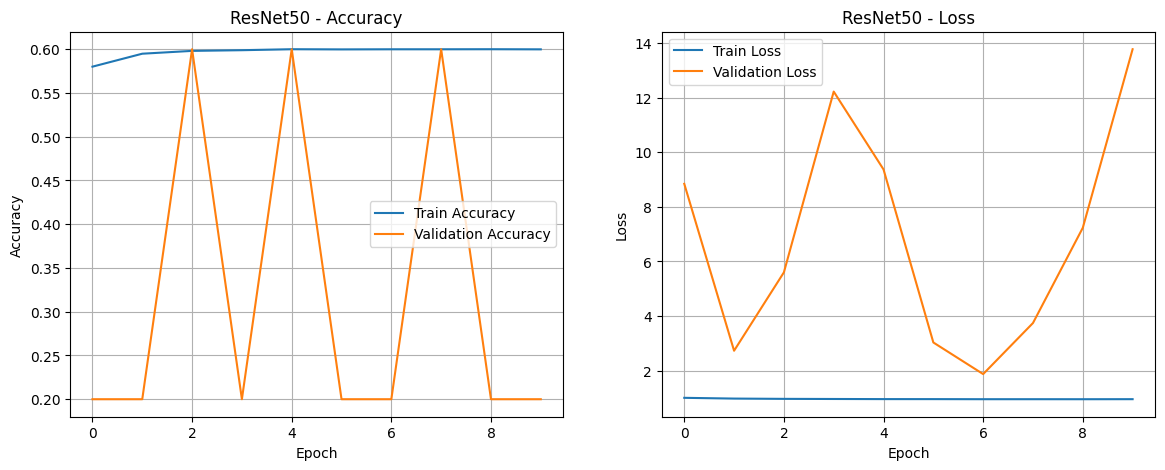

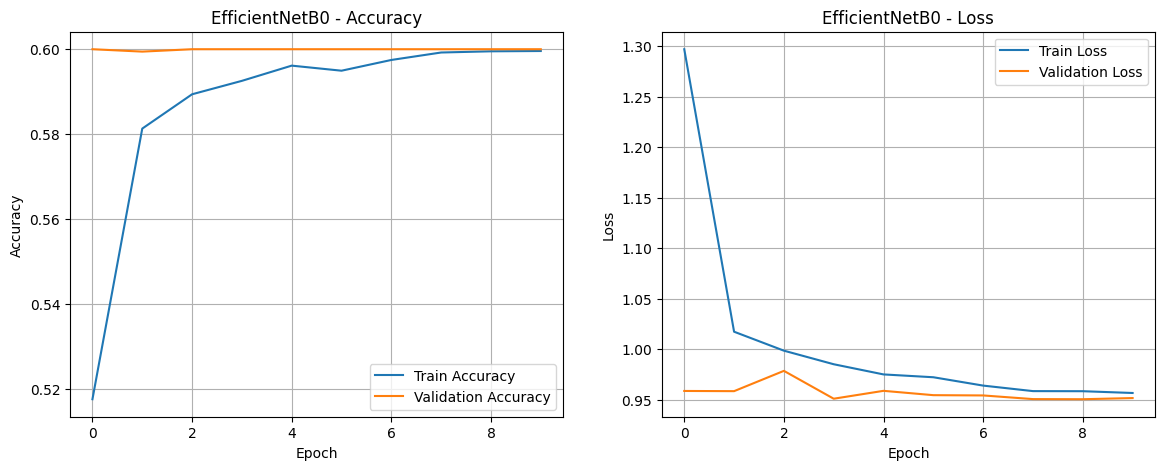

In [12]:
##--- Plot Training History ---
def plot_full_history(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title(f'{title} - Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title(f'{title} - Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

plot_full_history(resnet_history, 'ResNet50')
plot_full_history(efficientnet_history, 'EfficientNetB0')


112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2071 - loss: 1.8471

ResNet50 Validation Accuracy: 20.00%
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step


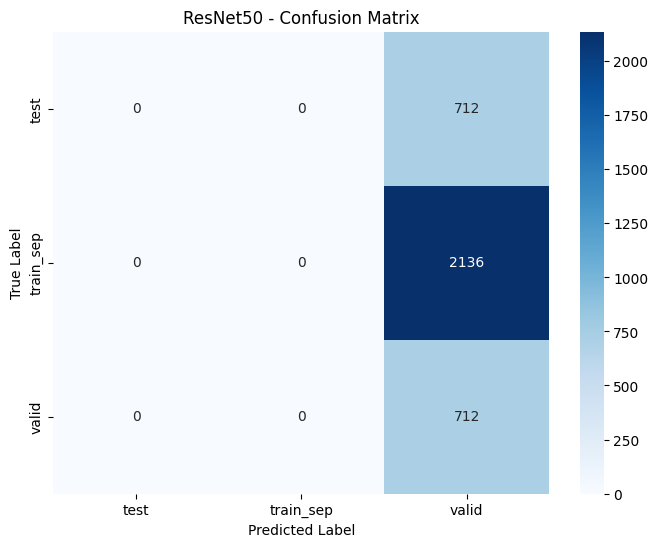


Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00       712
   train_sep       0.00      0.00      0.00      2136
       valid       0.20      1.00      0.33       712

    accuracy                           0.20      3560
   macro avg       0.07      0.33      0.11      3560
weighted avg       0.04      0.20      0.07      3560

  1/112 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6875 - loss: 0.8493

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5994 - loss: 0.9512

EfficientNetB0 Validation Accuracy: 60.00%
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


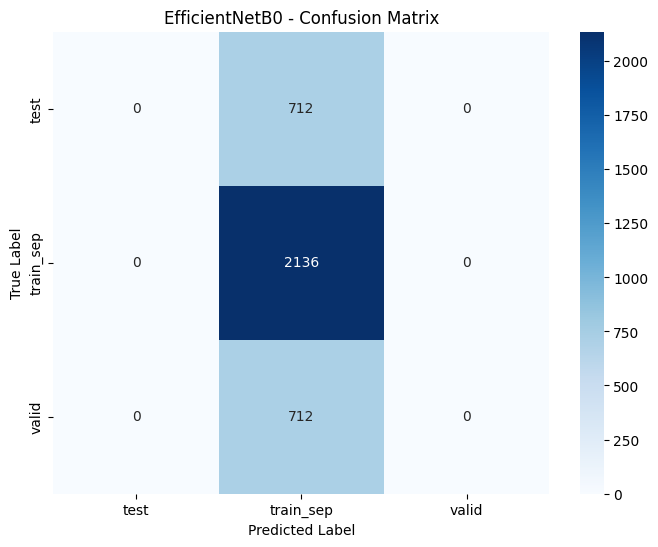


Classification Report:

              precision    recall  f1-score   support

        test       0.00      0.00      0.00       712
   train_sep       0.60      1.00      0.75      2136
       valid       0.00      0.00      0.00       712

    accuracy                           0.60      3560
   macro avg       0.20      0.33      0.25      3560
weighted avg       0.36      0.60      0.45      3560



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
##--- Evaluate Models ---
def evaluate_model(model, data, name):
    val_loss, val_acc = model.evaluate(data)
    print(f"\n{name} Validation Accuracy: {val_acc*100:.2f}%")

    y_true = data.classes
    y_pred = np.argmax(model.predict(data), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.class_indices, yticklabels=data.class_indices)
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=list(data.class_indices.keys())))

# Evaluate both models
evaluate_model(resnet_model, val_data, "ResNet50")
evaluate_model(efficientnet_model, val_data, "EfficientNetB0")
